### setting up

In [1]:
# Python Modules
import os
from sys import path as syspath
syspath.append("../")

from collections import OrderedDict
from collections.abc import Mapping
import pickle as pkl
from copy import deepcopy

# Data Modules
import numpy as np
import pandas as pd
from scipy.special import logsumexp
# from sklearn.linear_model import LogisticRegression, LinearRegression

# Util Modules
from util.td_model import ThermodynamicModel
from util.data_functions import *
from util.model_functions import *
# Bio Modules
from Bio import SeqIO

# Plotting Modules
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
def showdf(a_):
    from IPython.display import display
    display(a_.applymap("{0:0.1f}".format))

In [3]:
with open("../models/fitted_on_Pr.Pl.36N/model_[5]_extended", "rb") as f:
    model = pkl.load(f)

C:\Users\drago\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
saveFolder = "../models/fitted_on_Pr.Pl.36N/extended_parameters/"

In [6]:
DataDict = {
    "Pr": pd.read_csv("../data/Pr_Pl_sequences/Pr_constitutive.csv", usecols=[0,1]),
#     "Pl": pd.read_csv("Pr_Pl_sequences/Pl_constitutive.csv", usecols=[0,1]),
#     "36N": pd.read_csv("36N_seqences/36N_constitutive.csv", usecols=[0,1])
}

RBSPos = {lib:getRBSpositions(DataDict[lib]) for lib in DataDict}

numData = createNumData(DataDict,tts=["all"])



### Unproductive transcript due to proximity to RBS

In [7]:

numAncestor = numData['all']["Pr"]["seqs"][0]

wtPr_cropped = "".join([bases[i] for i in numAncestor])

wtPr_full = DataDict["Pr"]["sequence"][0]

In [8]:
# cropped sequences do not have the rbs any more
wtPr_cropped.find("aggagaag"), wtPr_full.find("aggagaag")

(-1, 124)

In [9]:
# cropped sequences have the same first part
wtPr_full.find(wtPr_cropped)

0

The brickwall for a single sequence has 5 rows for each of the spacer options, where the number of positions within each layer is different. In the consensus layer, there should be $L-l+1$ energies, where $l=32$ is the RNAp footprint with consenus spacer. The rows with larger spacer values have less configurations, and vice versa. In the code, we right-flush the energies, and truncate rows to that with lowest number of configurations (larges spacer) -1 . In pracice this is $L-34$

In [10]:
genOffset = sum(model["Layout"])+model["spFlex"]

In [11]:
prBrickwall = getBrickDict({"Pr": numAncestor.reshape((1,-1))}, model)["Pr"][0]

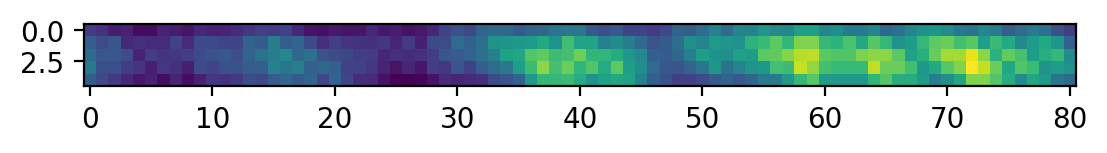

In [12]:
plt.imshow(np.exp(-prBrickwall.T*.04))

In [13]:
prBrickwall.shape[0], len(numAncestor)-genOffset

(81, 81)

The threshold position in the model (55) refers to the index of the free energy up to which the binding is considered productive. Therefore, to get the position in the sequence, we need to add the offset:

In [14]:
seqTh = model["ThDict"]["Pr.Pl"]+genOffset

In [15]:
wtPr_cropped[15:seqTh]+ " | " +wtPr_cropped[seqTh:]

'cctcgaggataaatatctaacaccgtgcgtgttgactattttacctctggcggtgataatggttgcatgtacta | gaattcattaaagaggagaaaggtac'

In [16]:
wtPr_full[15:seqTh]+ " | " +wtPr_full[seqTh:]

'cctcgaggataaatatctaacaccgtgcgtgttgactattttacctctggcggtgataatggttgcatgtacta | gaattcattaaagaggagaaaggtaccatgagtaaaggagaagaactttt'

In [17]:
RBSPos["Pr"]-seqTh

13

Therefore, we determine the closest promotor needs to finish 35 positions before the appropriate ribosomal binding site.

### Matrices and chemical potentials

In [18]:
m = np.vstack(model["matrices"])
chempots = pd.Series(model["chem.pot"])

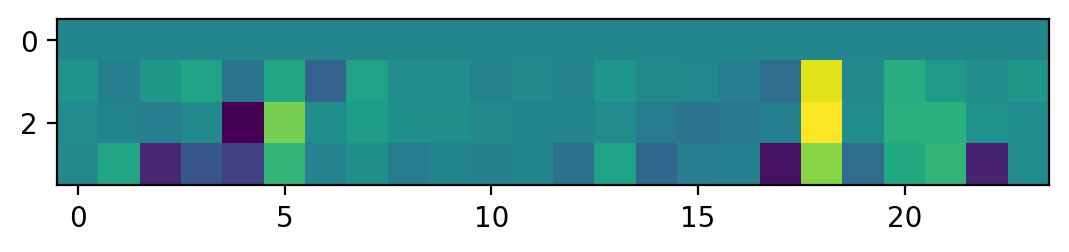

In [19]:
plt.imshow(m.T)

In [20]:
bEoffset = m.min(axis=1)

In [21]:
m-=np.repeat([bEoffset], 4, axis=0).T
chempots -= bEoffset.sum()

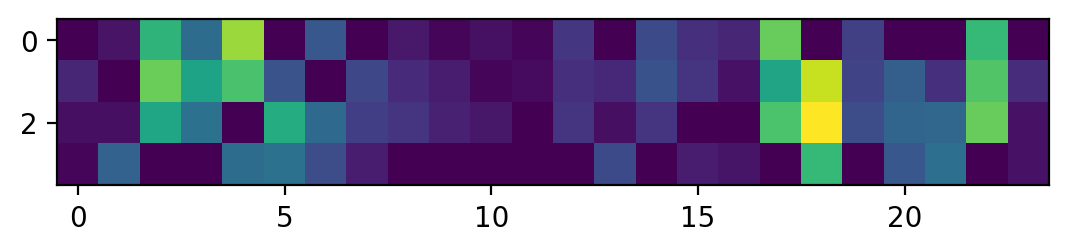

In [22]:
plt.imshow(m.T)

In [23]:
chempots

Pr.Pl    11.128164
36N      10.531435
dtype: float64

In [24]:
lps2eval(model, "mlogL", fit=False, tt="all", numData=numData, DataIDs_=["Pr"])

{'Pr': 139174.406307146}

In [25]:
tmpmodel = deepcopy(model)
tmpmodel["chem.pot"] = chempots.to_dict()
n1 = model["Layout"][0]
tmpmodel["matrices"] = m[:n1], m[n1:]

In [26]:
lps2eval(tmpmodel, "mlogL", fit=False, tt="all", numData=numData, DataIDs_=["Pr"])

# Pr 9663

C:\Users\drago\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


{'Pr': inf}

In [21]:
np.savetxt(saveFolder+"matrix-35.txt", m[:n1], fmt="%.4f", header="A C G T")

In [22]:
np.savetxt(saveFolder+"matrix-10.txt", m[n1:], fmt="%.4f", header="A C G T")

In [25]:
chempots.to_csv(saveFolder+"chem_pots.txt")

In [29]:
np.savetxt(saveFolder+"chem_pots.txt", chempots.values.reshape(1,-1), fmt="%.3f", header=" ".join(chempots.keys()))

### Clearance Rate and spacer penalties

In [36]:
with open(saveFolder+"clearance_rate.txt","w") as f:
    f.write("%.3f"%np.exp(model["logClearanceRate"]))

In [38]:
np.savetxt(saveFolder+"spacer_penalties.txt", model["sp.penalties"].reshape(1,-1), fmt="%.3f", header=" ".join([str(i) for i in range(-2,3)]))